<a href="https://colab.research.google.com/github/ErikMayerPSU/AuroraNSL_2024/blob/main/Code/viewline/Generating_viewlines_and_plotting_2025_0329_1330.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

View Lines

Based on binary_classification_2024_0627_a0935, https://github.com/ErikMayerPSU/AuroraNSL_2024/blob/main/Code/binary_classification_development/binary_classification_2024_0627_a0935.ipynb


Attempting to fill in missing viewline values, this version does not completely work




In [53]:
import logging; logging.basicConfig(level=logging.INFO)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import numpy as np

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

Read data from St Patrick's Day Eflux (OP-13 output) file on GitHub (see File_reading_2024_0623_a0607.ipynb)

In [54]:
# OP-13 data

df_eflux = pd.read_csv(r"https://raw.githubusercontent.com/ErikMayerPSU/AuroraNSL_2024/main/data/St%20patrick's%20day%202015/Eflux/20150318_0200UT_Eflux_e%2Call.txt", header=None, skiprows=1, nrows=7680, sep='\s+', on_bad_lines='skip')

# Define new headers
eflux_headers = ["MLT", "ML", "[mW m^-2]"]

# Set the column headers
df_eflux.columns = eflux_headers

#add column for visibility threshold (VT) T/F
df_eflux["VT"]= 0

#Set VT to 1 or 0 based on aurora visibility threshold of 1 mW m^-2
df_eflux.loc[df_eflux["[mW m^-2]"]>=1, "VT"] = 1

df_eflux

,MLT,ML,[mW m^-2],VT
0,0.00,50.0,0.009205,0
1,0.00,50.5,0.009303,0
2,0.00,51.0,0.005775,0
3,0.00,51.5,0.020590,0
4,0.00,52.0,0.000387,0
...,...,...,...,...
7675,23.75,87.5,0.023140,0
7676,23.75,88.0,0.022190,0
7677,23.75,88.5,0.023080,0
7678,23.75,89.0,0.016270,0



## **Add viewline column**

In [55]:
#add a column for the equatorial boundry (EB) and viewline (VL)
df_eflux["EB"] = 0 #initialize as 0 not "0"
df_eflux["VL"] = 0

last_j = 0 #initialize last j

#apply viewline equation to OP-13 data
for i in range(len(df_eflux["MLT"])):

  #find first instance of visibility threshold being 1 for each MLT value 0-24
  selected_rows = df_eflux.loc[(df_eflux["MLT"] == i/4) & (df_eflux["VT"] >= 1)]

  # Check that there is an instance of the VT being 1 in this value of MLT
  if not selected_rows.empty:
    j = selected_rows.index[0]

    #2/13/25 added if statement to attempt to remove outliars

    if (abs(df_eflux.loc[last_j,"ML"]-df_eflux.loc[j,"ML"]) < 1):



    # Set the EB column to show the first instance of visibility threshold being
    # 1 for each MLT value 0-24
      df_eflux.loc[j,"EB"] = 1
    # Set the viewline based on the EB VL equation
      df_eflux.loc[j-8,"VL"] = 1

    last_j = j

#df_eflux

In [56]:
# Filter to get the MLT and ML coordinates of all rows where the VL is present
VL_df = df_eflux[df_eflux['VL'] == 1]
VL_df = VL_df[['MLT','ML']]

# Find missing values of MLT and add them to the VL dataframe with a ML of NaN
MLT_vals = df_eflux['MLT'].unique()
Missing_MLT = set(MLT_vals) - set(VL_df['MLT'])
VL_df = pd.concat([VL_df, pd.DataFrame({'MLT': list(Missing_MLT), 'ML': [np.nan] * len(Missing_MLT)})])

# Fix order and index
VL_df = VL_df.sort_values(by='MLT').reset_index(drop=True)

#VL_df

In [57]:
# Interpolate missing viewline points
# Use limit = 10 to avoid filling large gaps, such as the middle of the VL
VL_df = VL_df.interpolate(method='linear', axis=0, limit=10)
VL_df = VL_df.interpolate(method='linear', axis=0, limit_direction='both', limit_area='outside') # Ensure edges are filled

#Round the values of ML to the nearest 0.5 value so they fit in the established bins
VL_df['ML'] = (VL_df['ML'] * 2).round() / 2

#VL_df

In [58]:
#Create new row for interpolated VL in df_eflux
df_eflux['New_VL'] = 0

#Set New_VL to 1 for rows corresponding to the MLT and ML coordinates in VL_df
for i, row in VL_df.iterrows():
    mlt = row['MLT']
    ml = row['ML']
    if not pd.isna(ml):  # Skip rows where ML is NaN
        df_eflux.loc[(df_eflux['MLT'] == mlt) & (df_eflux['ML'] == ml), 'New_VL'] = 1

#df_eflux

In [59]:
# Create an array of the New_VL column
array_eflux = df_eflux.to_numpy()
array_VIS = array_eflux[0:7680,6:7]

# Set visibilty to a "1" from the viewline to 90 MLT
for i in range(96):
    array_temp = array_VIS[(i*80):((i+1)*80),0:1]

    try:
        # Find the index of the first occurrence of 1 in array_temp
        idx = np.where(array_temp == 1)[0][0]  # Use np.where to find the index
        #print(idx)
        array_VIS[(i*80)+idx:((i+1)*80),0:1] = 1
        #for j in range(idx):
            #array_VL[i * 80 + (80 - j)] = 1 #Fixed index out of range error
            #print(i * 80 + (80 - j))
    except IndexError: #Changed to IndexError since np.where returns an empty array if the value is not found which leads to an IndexError
        logging.NullHandler

#array_VIS

In [60]:
# Add the visibility array back to eflux_df
df_eflux['VIS'] = pd.DataFrame(array_VIS, columns=['VIS'])
df_eflux

,MLT,ML,[mW m^-2],VT,EB,VL,New_VL,VIS
0,0.00,50.0,0.009205,0,0,0,0,0.0
1,0.00,50.5,0.009303,0,0,0,0,0.0
2,0.00,51.0,0.005775,0,0,0,0,0.0
3,0.00,51.5,0.020590,0,0,0,0,0.0
4,0.00,52.0,0.000387,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...
7675,23.75,87.5,0.023140,0,0,0,0,1.0
7676,23.75,88.0,0.022190,0,0,0,0,1.0
7677,23.75,88.5,0.023080,0,0,0,0,1.0
7678,23.75,89.0,0.016270,0,0,0,0,1.0


## **Generate Plots**

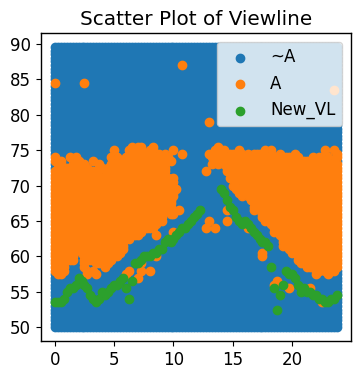

In [67]:
plt.figure(figsize=(4,4))

#reverse plot order to better see A points
plt.scatter(df_eflux["MLT"][np.logical_not(df_eflux['VT'].astype(bool))], df_eflux["ML"][np.logical_not(df_eflux['VT'].astype(bool))], label='~A')
plt.scatter(df_eflux["MLT"][df_eflux['VT'].astype(bool)], df_eflux["ML"][df_eflux['VT'].astype(bool)], label='A')

#Plot VL
plt.scatter(df_eflux["MLT"][df_eflux["New_VL"].astype(bool)], df_eflux["ML"][df_eflux["New_VL"].astype(bool)], label='New_VL')

plt.title("Scatter Plot of Viewline")
plt.legend()
plt.show()


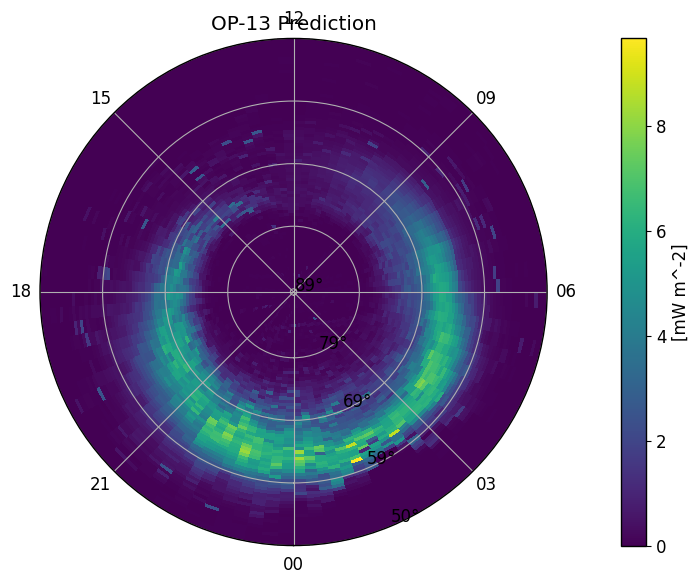

In [61]:
# Reshape into a grid (MLT=rows, ML=columns)
grid = df_eflux.pivot(index='MLT', columns='ML', values='[mW m^-2]')

# Convert MLT to radians
theta = np.deg2rad(grid.index * 15)  # 15° per hour

#Invert ML since the plot was backward
ml = grid.columns.values
ml_inverted = ml.max() - ml

# Extend edges for pcolormesh
theta_edges = np.append(theta, theta[0] + 2*np.pi)  # Close the loop (24h)
ml_edges = np.append(ml_inverted, ml_inverted[-1] + np.diff(ml_inverted)[0])  # Extend edges


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})
pc = ax.pcolormesh(
    theta_edges,
    ml_edges,
    grid.T,  # Transpose to match (ML, MLT)
    cmap='viridis',
    shading='auto'
)

ax.set_theta_zero_location('S')  # 0° at bottom
ax.set_theta_direction(1)       # Set correct direction for MLT

# Label MLT ticks
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels(['00', '03', '06', '09', '12', '15', '18', '21'])

# Label ML ticks
r_ticks = np.linspace(ml.min(), ml.max(), 5)
ax.set_yticks(ml.max() - r_ticks)
ax.set_yticklabels([f'{int(x)}°' for x in r_ticks])

# Add labels and colorbar
#ax.set_xlabel('Magnetic Local Time (MLT)')
#ax.set_ylabel('Magnetic Latitude (ML)')
plt.colorbar(pc, label='[mW m^-2]', pad=0.1)
plt.title('OP-13 Prediction')
plt.tight_layout()
plt.show()

(7680, 3)
[[0.         0.59650493 0.8867    ]
 [0.         0.57662144 0.4976    ]
 [0.         0.55673794 0.4575    ]
 [0.         0.53685444 0.07561   ]
 [0.         0.51697094 0.1537    ]
 [0.         0.49708745 0.6761    ]
 [0.         0.47720395 0.1659    ]
 [0.         0.45732045 0.09664   ]
 [0.         0.43743695 0.09386   ]
 [0.         0.41755345 0.02922   ]
 [0.         0.39766996 0.04782   ]]
(80, 96)
(80, 96)


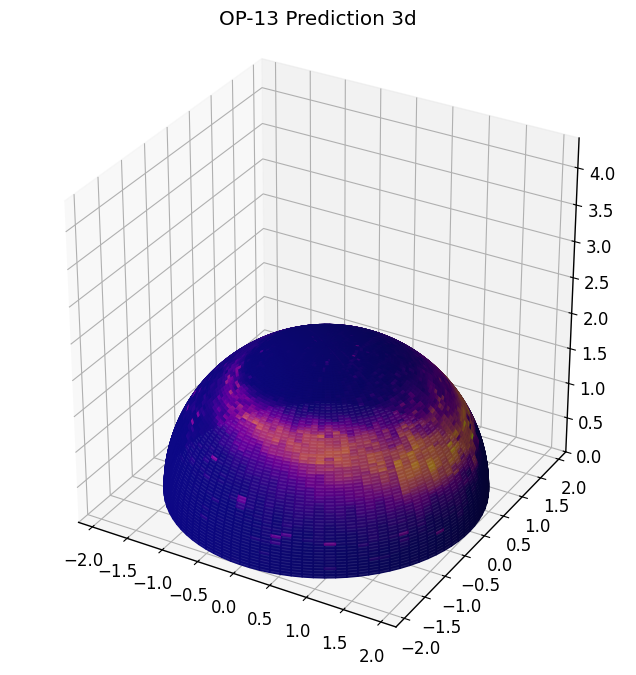

In [62]:
#theta inclination angle
#phi azimuthal angle
n_theta = 80 # number of values for theta (ML)
n_phi = 96  # number of values for phi (MLT)
r = 2        #radius of sphere

# Reversed range for theta since it was plotting backwards
theta, phi = np.mgrid[0.5*np.pi:0.0:n_theta*1j, 0.0:2.0*np.pi:n_phi*1j]

x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

# mimic the input array
# array columns phi, theta, value
# first n_theta entries: phi=0, second n_theta entries: phi=0.0315..
inp = []
index = 0
for j in phi[0,:]:
    for i in theta[:,0]:
        val = df_eflux['[mW m^-2]'].iloc[index]# put something useful here
        inp.append([j, i, val])
        index += 1
inp = np.array(inp)
print(inp.shape)
print(inp[49:60, :])

#reshape the input array to the shape of the x,y,z arrays.
c = inp[:,2].reshape((n_phi,n_theta)).T
print(z.shape)
print(c.shape)


#Set colours and render
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
#use facecolors argument, provide array of same shape as z
# cm.() allows to get rgba color from array.
# array must be normalized between 0 and 1
ax.plot_surface(
    x,y,z,  rstride=1, cstride=1, facecolors=cm.plasma(c/c.max()), alpha=0.9, linewidth=1)
ax.set_xlim([-2.2,2.2])
ax.set_ylim([-2.2,2.2])
ax.set_zlim([0,4.4])
ax.set_aspect("equal")
plt.title('OP-13 Prediction 3d')
#ax.plot_wireframe(x, y, z, color="k") #not needed?!
#plt.savefig(__file__+".png")
plt.show()

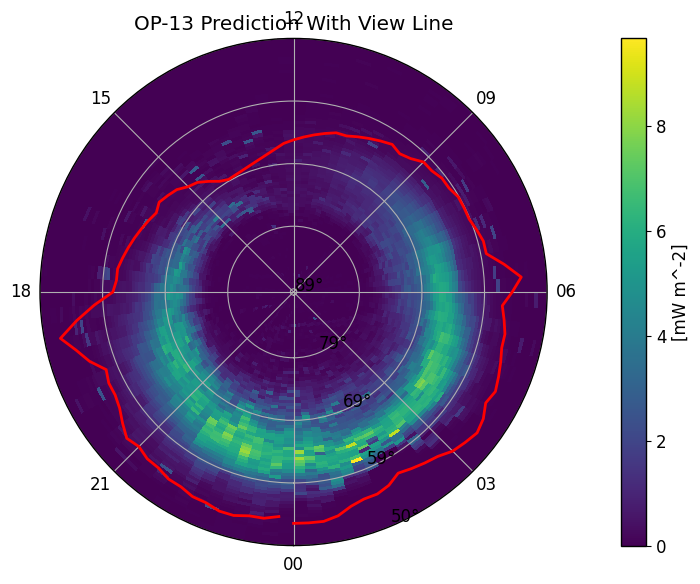

In [63]:
# Reshape into a grid (MLT=rows, ML=columns)
grid = df_eflux.pivot(index='MLT', columns='ML', values='[mW m^-2]')

# Convert MLT to radians
theta = np.deg2rad(grid.index * 15)  # 15° per hour

#Invert ML since the plot was backward
ml = grid.columns.values
ml_inverted = ml.max() - ml

# Extend edges for pcolormesh
theta_edges = np.append(theta, theta[0] + 2*np.pi)  # Close the loop (24h)
ml_edges = np.append(ml_inverted, ml_inverted[-1] + np.diff(ml_inverted)[0])  # Extend edges


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})
pc = ax.pcolormesh(
    theta_edges,
    ml_edges,
    grid.T,  # Transpose to match (ML, MLT)
    cmap='viridis',
    shading='auto'
)

ax.set_theta_zero_location('S')  # 0° at bottom
ax.set_theta_direction(1)       # Set correct direction for MLT

# Label MLT ticks
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels(['00', '03', '06', '09', '12', '15', '18', '21'])

# Label ML ticks
r_ticks = np.linspace(ml.min(), ml.max(), 5)
ax.set_yticks(ml.max() - r_ticks)
ax.set_yticklabels([f'{int(x)}°' for x in r_ticks])

# Add labels and colorbar
#ax.set_xlabel('Magnetic Local Time (MLT)')
#ax.set_ylabel('Magnetic Latitude (ML)')
plt.colorbar(pc, label='[mW m^-2]', pad=0.1)

# Add view line to plot

# Get the geomagnetic coordinates of view line
view_points = df_eflux[df_eflux['New_VL'] == 1]
view_MLT = view_points['MLT'].values
view_ML = view_points['ML'].values

# Convert to polar coordinates (same as main plot)
view_theta = np.deg2rad(view_MLT * 15)  # MLT to radians
view_ml_inverted = ml.max() - view_ML   # Invert ML

# Plot the view line in red
ax.plot(
    view_theta, view_ml_inverted,
    color='red', linewidth=2,
)


plt.title('OP-13 Prediction With View Line')
plt.tight_layout()
plt.show()

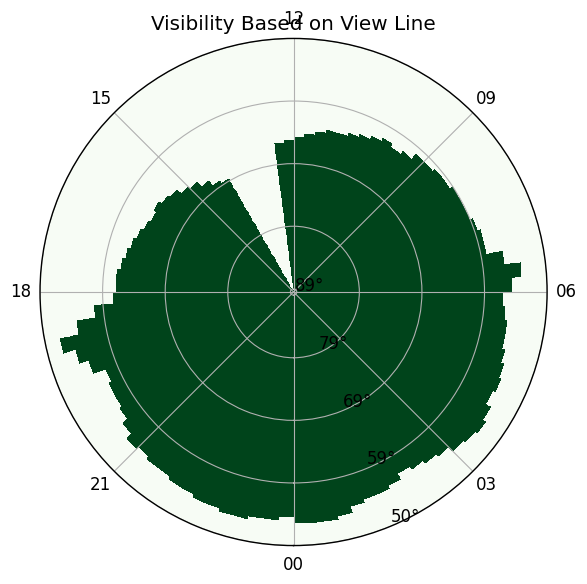

In [64]:
# Reshape into a grid (MLT=rows, ML=columns)
grid = df_eflux.pivot(index='MLT', columns='ML', values='VIS')

# Convert MLT to radians
theta = np.deg2rad(grid.index * 15)  # 15° per hour

#Invert ML since the plot was backward
ml = grid.columns.values
ml_inverted = ml.max() - ml

# Extend edges for pcolormesh
theta_edges = np.append(theta, theta[0] + 2*np.pi)  # Close the loop (24h)
ml_edges = np.append(ml_inverted, ml_inverted[-1] + np.diff(ml_inverted)[0])  # Extend edges


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})
pc = ax.pcolormesh(
    theta_edges,
    ml_edges,
    grid.T,  # Transpose to match (ML, MLT)
    cmap='Greens',
    shading='auto'
)

ax.set_theta_zero_location('S')  # 0° at bottom
ax.set_theta_direction(1)       # Set correct direction for MLT

# Label MLT ticks
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels(['00', '03', '06', '09', '12', '15', '18', '21'])

# Label ML ticks
r_ticks = np.linspace(ml.min(), ml.max(), 5)
ax.set_yticks(ml.max() - r_ticks)
ax.set_yticklabels([f'{int(x)}°' for x in r_ticks])

# Add labels and colorbar
#ax.set_xlabel('Magnetic Local Time (MLT)')
#ax.set_ylabel('Magnetic Latitude (ML)')
#plt.colorbar(pc, label='[mW m^-2]', pad=0.1)
plt.title('Visibility Based on View Line')
plt.tight_layout()
plt.show()

(7680, 3)
[[0.         0.59650493 1.        ]
 [0.         0.57662144 1.        ]
 [0.         0.55673794 1.        ]
 [0.         0.53685444 1.        ]
 [0.         0.51697094 1.        ]
 [0.         0.49708745 1.        ]
 [0.         0.47720395 1.        ]
 [0.         0.45732045 1.        ]
 [0.         0.43743695 1.        ]
 [0.         0.41755345 1.        ]
 [0.         0.39766996 1.        ]]
(80, 96)
(80, 96)


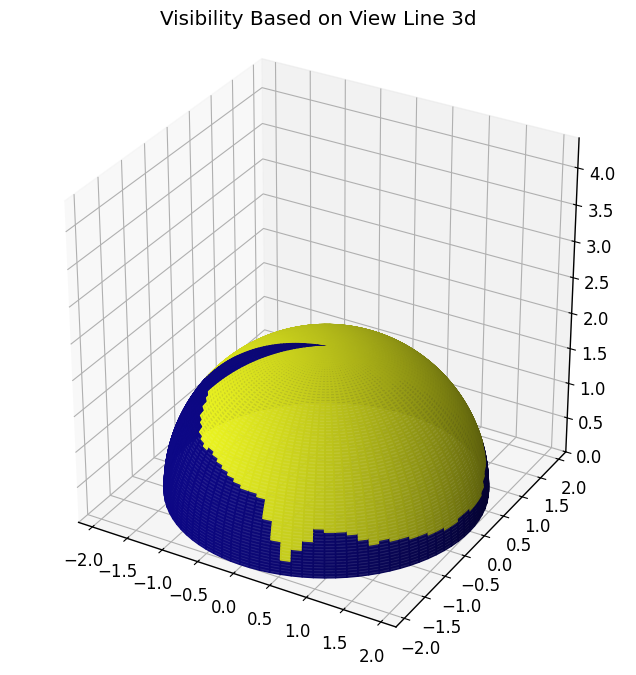

In [66]:
#theta inclination angle
#phi azimuthal angle
n_theta = 80 # number of values for theta (ML)
n_phi = 96  # number of values for phi (MLT)
r = 2        #radius of sphere

# Reversed range for theta since it was plotting backwards
theta, phi = np.mgrid[0.5*np.pi:0.0:n_theta*1j, 0.0:2.0*np.pi:n_phi*1j]

x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

# mimic the input array
# array columns phi, theta, value
# first n_theta entries: phi=0, second n_theta entries: phi=0.0315..
inp = []
index = 0
for j in phi[0,:]:
    for i in theta[:,0]:
        val = df_eflux['VIS'].iloc[index]# put something useful here
        inp.append([j, i, val])
        index += 1
inp = np.array(inp)
print(inp.shape)
print(inp[49:60, :])

#reshape the input array to the shape of the x,y,z arrays.
c = inp[:,2].reshape((n_phi,n_theta)).T
print(z.shape)
print(c.shape)


#Set colours and render
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
#use facecolors argument, provide array of same shape as z
# cm.() allows to get rgba color from array.
# array must be normalized between 0 and 1
ax.plot_surface(
    x,y,z,  rstride=1, cstride=1, facecolors=cm.plasma(c/c.max()), alpha=0.9, linewidth=1)
ax.set_xlim([-2.2,2.2])
ax.set_ylim([-2.2,2.2])
ax.set_zlim([0,4.4])
ax.set_aspect("equal")
plt.title('Visibility Based on View Line 3d')
#ax.plot_wireframe(x, y, z, color="k") #not needed?!
#plt.savefig(__file__+".png")
plt.show()